Importing Modules and Seed Setting

In [1]:
import os
import numpy as np
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
from torch.cuda.amp import autocast, GradScaler
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score
import time

#Random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

Parameters Configuration

In [2]:
path = Path("./preprocessed_patches") 
batch_size = 8
learning_rate = 0.001
max_epochs = 50
rgb_channels = 3 
segmentation_classes = 1 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


Data Transforms

In [3]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=10)
])

Dataset Class

In [4]:
class SatellitePatchDataset(Dataset):
    def __init__(self, path, transform=None, is_training=True):
        self.path = Path(path)
        self.image_paths = []
        self.mask_paths = []
        self.transform=transform
        self.is_training = is_training
        
        #Collecting image-mask pairs
        for city_dir in self.path.iterdir():
            if city_dir.is_dir():
                for img_path in city_dir.glob("patch_*.png"):
                    if "_gt.png" not in img_path.name:
                        mask_path = img_path.parent / f"{img_path.stem}_gt.png"
                        if mask_path.exists():
                            self.image_paths.append(img_path)
                            self.mask_paths.append(mask_path)
                        else:
                            print(f"Warning: Corresponding mask not found for {img_path}")

        print(f"Found {len(self.image_paths)} image-mask pairs across all cities.")
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):        
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        
        #Load and preprocess image and mask
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        
        #Converting to numpy arrays and normalizing
        image = np.array(image, dtype=np.float32) / 255.0 
        mask = np.array(mask, dtype=np.float32) / 255.0
        
        #Applying random transformations to both image and mask
        if self.transform and self.is_training:
            #Convert to PIL for transformations
            image_pil = transforms.ToPILImage()(image.transpose(2, 0, 1))
            mask_pil = transforms.ToPILImage()(mask)
            
            #Applying Random Seed
            seed = random.randint(2147483647)
            
            torch.manual_seed(seed)
            mask_pil = self.transform(mask_pil)
            
            #Converting back to numpy
            image = np.array(image_pil, dtype=np.float32) / 255.0
            mask = np.array(mask_pil, dtype=np.float32) / 255.0
            
        #Converting to proper tensor format
        image = np.transpose(image, (2, 0, 1)) # HWC to CHW
        mask = np.expand_dims(mask, axis=0) #Adding channel dimension
        
        #Converting to tensor
        image_tensor = torch.from_numpy(image)
        mask_tensor = torch.from_numpy(mask)   
        
        #Ensuring the mask is binary
        mask_tensor = (mask_tensor > 0.5).float()
        
        return image_tensor, mask_tensor


U-Net Model Architecture

In [5]:
#U-Net Model Components

class DoubleConv(nn.Module):
    """Double convolution block with BatchNorm and ReLU"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downsampling block with maxpool followed by double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upsampling block with transpose conv and skip connections"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        #Handle Size Mismatch
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2,
                                    diffY // 2, diffY - diffY // 2])
        
        #Concatenate skip connection
        x = torch.cat([x2, x1], dim=1)
        
        return self.conv(x)


class OutConv(nn.Module):
    """Final output convolution"""
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    """Complete U-Net Architecture"""
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        #Encoder
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        
        #Decoder
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        #Encoder path
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        #Decoder path with skip connections
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        
        return logits


Evaluation Metrics

In [6]:
def calculate_iou(pred, target, threshold=0.5):
    """Calculate Intersection over Union (IoU)"""
    pred_binary = (pred > threshold).float()
    target_binary = (target > threshold).float()
    
    intersection = (pred_binary * target_binary).sum()
    union = pred_binary.sum() + target_binary.sum() - intersection
    
    if union == 0:
        return 1.0 if intersection == 0 else 0.0
    
    return (intersection / union).item()

def calculate_metrics(predictions, targets, threshold=0.5):
    """Calculate precision, recall, F1-score and IoU"""
    pred_binary = (predictions > threshold).cpu().numpy().flatten()
    target_binary = targets.cpu().numpy().flatten()
    
    precision = precision_score(target_binary, pred_binary, zero_division=0)
    recall = recall_score(target_binary, pred_binary, zero_division=0)
    f1 = f1_score(target_binary, pred_binary, zero_division=0)
    
    #Calculate IoU
    intersection = np.sum(pred_binary * target_binary)
    union = np.sum(pred_binary) + np.sum(target_binary) - intersection
    iou = intersection / union if union > 0 else 0.0
    
    return precision, recall, f1, iou

Data Loading and Splitting

In [7]:
max_epochs = 10
batch_size = 8
patience = 5

print("Loading dataset...")
full_dataset = SatellitePatchDataset(path, transform=train_transforms, is_training=True)

#Splitting dataset into training and validation sets
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

#Create validation dataset without augmentation
val_dataset.dataset.transform = None
val_dataset.dataset.is_training = False

#Creating DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

print(f"Training Samples: {len(train_dataset)}")
print(f"Validation Samples: {len(val_dataset)}")
print(f"Estimated time per epoch: {len(train_loader) * 35 / 1800:.1f} minutes")
print(f"Total estimated training time: {len(train_loader) * 35 / 1800 * max_epochs:.1f} minutes")

Loading dataset...
Found 18000 image-mask pairs across all cities.
Training Samples: 14400
Validation Samples: 3600
Estimated time per epoch: 35.0 minutes
Total estimated training time: 350.0 minutes


Model Initialization

In [8]:
model = UNet(n_channels=rgb_channels, n_classes=segmentation_classes)
model.to(device) #Using GPU

#Loss function and optimizer
criterion = nn.BCEWithLogitsLoss() # Binary classification 
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

#Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

Training Loop

In [ ]:
# Reset GPU state for optimal performance
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True  # Optimize for consistent input sizes


def load_checkpoint(checkpoint_path, model, optimizer, scheduler, device):
    """Load checkpoint and return training state"""
    if os.path.exists(checkpoint_path):
        print("Loading checkpoint...")
        checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
        
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        
        start_epoch = checkpoint['epoch'] + 1
        best_iou = checkpoint['best_iou']
        train_losses = checkpoint['train_losses']
        val_losses = checkpoint['val_losses'] 
        val_ious = checkpoint['val_ious']
        
        print(f"Resumed from epoch {start_epoch}, best IoU: {best_iou:.4f}")
        return start_epoch, best_iou, train_losses, val_losses, val_ious
    else:
        print("No checkpoint found, starting from scratch...")
        return 0, 0.0, [], [], []

def save_checkpoint(epoch, model, optimizer, scheduler, best_iou, train_losses, val_losses, val_ious, filepath):
    """Save training checkpoint"""
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'best_iou': best_iou,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_ious': val_ious
    }, filepath)

checkpoint_path = 'best_unet_model.pth'
start_epoch, best_iou, train_losses, val_losses, val_ious = load_checkpoint(
    checkpoint_path, model, optimizer, scheduler, device
)


# Initialize mixed precision scaler
scaler = GradScaler()

# Early stopping variables
best_val_loss = float('inf')
patience_counter = 0
start_time = time.time()

def print_gpu_memory():
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1024**3
        cached = torch.cuda.memory_reserved() / 1024**3
        print(f"GPU Memory - Allocated: {allocated:.2f}GB, Cached: {cached:.2f}GB")

def format_time(seconds):
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    return f"{int(hours)}h {int(minutes)}m"

print("Starting training...")
if start_epoch > 0:
    print(f"Resuming from epoch {start_epoch + 1}")
print_gpu_memory()

for epoch in range(start_epoch, max_epochs):
    epoch_start_time = time.time()
    # Clear cache at the start of each epoch
    torch.cuda.empty_cache()
    
    # Training Phase
    model.train()
    running_loss = 0.0
    
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{max_epochs} [Train]")
    for batch_idx, (images, masks) in enumerate(train_pbar):
        images = images.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)
        
        optimizer.zero_grad()
        
        # Use mixed precision
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, masks)
        
        # Scale loss and backward pass
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item()
        # Update progress bar every 10 batches to reduce overhead
        if batch_idx % 10 == 0:
            train_pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Avg Loss': f'{running_loss/(batch_idx+1):.4f}'
            })
        
        # Clear variables to free memory
        del images, masks, outputs, loss
        
    epoch_train_loss = running_loss / len(train_loader)
    train_losses.append(epoch_train_loss)
    
    #Validation Phase
    model.eval()
    val_running_loss = 0.0
    val_ious_batch = []
    val_precisions = []
    val_recalls = []
    val_f1s = []
    
    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{max_epochs} [Val]")
        for batch_idx, (images, masks) in enumerate(val_pbar):
            images = images.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True)
            
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, masks)
                
            val_running_loss += loss.item()
            
            # Calculate metrics
            predictions = torch.sigmoid(outputs)
            precision, recall, f1, iou = calculate_metrics(predictions, masks)
            
            val_ious_batch.append(iou)
            val_precisions.append(precision)
            val_recalls.append(recall)
            val_f1s.append(f1)
            
            # Update progress bar every 5 batches
            if batch_idx % 5 == 0:
                val_pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'IoU': f'{iou:.4f}'
                })
            
            # Clear variables to free memory
            del images, masks, outputs, predictions, loss
    
    epoch_val_loss = val_running_loss / len(val_loader)
    epoch_val_iou = np.mean(val_ious_batch)
    epoch_val_precision = np.mean(val_precisions)
    epoch_val_recall = np.mean(val_recalls)
    epoch_val_f1 = np.mean(val_f1s)
    
    val_losses.append(epoch_val_loss)
    val_ious.append(epoch_val_iou)
    
    # LEARNING RATE SCHEDULING
    scheduler.step(epoch_val_loss)
    
    # SAVE BEST MODEL
    if epoch_val_iou > best_iou:
        best_iou = epoch_val_iou
        save_checkpoint(epoch, model, optimizer, scheduler, best_iou, 
                       train_losses, val_losses, val_ious, 'best_unet_model.pth')
        print(f"New best model saved with IoU: {best_iou:.4f}")
        
    # EARLY STOPPING LOGIC
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        
    # TIME CALCULATIONS AND DISPLAY
    epoch_time = time.time() - epoch_start_time
    elapsed_time = time.time() - start_time
    estimated_total_time = elapsed_time * max_epochs / (epoch + 1)
    remaining_time = estimated_total_time - elapsed_time
        
    print(f"Epoch {epoch+1}/{max_epochs}:")
    print(f"  Train Loss: {epoch_train_loss:.4f}")
    print(f"  Val Loss: {epoch_val_loss:.4f}")
    print(f"  Val IoU: {epoch_val_iou:.4f}")
    print(f"  Val Precision: {epoch_val_precision:.4f}")
    print(f"  Val Recall: {epoch_val_recall:.4f}")
    print(f"  Val F1-Score: {epoch_val_f1:.4f}")
    print(f"  Epoch Time: {format_time(epoch_time)}")
    print(f"  Remaining Time: {format_time(remaining_time)}")
    print("-" * 50)
    
    # Print memory usage
    print_gpu_memory()
    
    # EARLY STOPPING CHECK
    if patience_counter >= patience:
        print(f"\nEARLY STOPPING triggered at epoch {epoch+1}")
        print(f"No improvement in validation loss for {patience} epochs")
        break

# TRAINING COMPLETE
print("Training Complete!")
print(f"Best Validation IoU: {best_iou:.4f}")

# Save final checkpoint
save_checkpoint(epoch, model, optimizer, scheduler, best_iou, train_losses, val_losses, val_ious, 'final_unet_model.pth')
print("Final model saved!")

Loading checkpoint...
Resumed from epoch 5, best IoU: 0.6790
Starting training...
Resuming from epoch 6
GPU Memory - Allocated: 0.35GB, Cached: 0.49GB


C:\Users\ayush\AppData\Local\Temp\ipykernel_26072\469453230.py:50: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 6/10 [Train]:   0%|          | 0/1800 [00:00<?, ?it/s]

C:\Users\ayush\AppData\Local\Temp\ipykernel_26072\469453230.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 6/10 [Val]:   0%|          | 0/450 [00:00<?, ?it/s]

C:\Users\ayush\AppData\Local\Temp\ipykernel_26072\469453230.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ayush\AppData\Local\Temp\ipykernel_26072\469453230.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ayush\AppData\Local\Temp\ipykernel_26072\469453230.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ayush\AppData\Local\Temp\ipykernel_26072\469453230.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ayush\AppData\Local\Temp\ipykernel_26072\469453230.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autoc

New best model saved with IoU: 0.6974
Epoch 6/10:
  Train Loss: 0.1421
  Val Loss: 0.1379
  Val IoU: 0.6974
  Val Precision: 0.8462
  Val Recall: 0.7995
  Val F1-Score: 0.8198
  Epoch Time: 0h 29m
  Remaining Time: 0h 19m
--------------------------------------------------
GPU Memory - Allocated: 0.47GB, Cached: 7.61GB


Epoch 7/10 [Train]:   0%|          | 0/1800 [00:00<?, ?it/s]

C:\Users\ayush\AppData\Local\Temp\ipykernel_26072\469453230.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 7/10 [Val]:   0%|          | 0/450 [00:00<?, ?it/s]

C:\Users\ayush\AppData\Local\Temp\ipykernel_26072\469453230.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ayush\AppData\Local\Temp\ipykernel_26072\469453230.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ayush\AppData\Local\Temp\ipykernel_26072\469453230.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ayush\AppData\Local\Temp\ipykernel_26072\469453230.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ayush\AppData\Local\Temp\ipykernel_26072\469453230.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autoc

Epoch 7/10:
  Train Loss: 0.1384
  Val Loss: 0.1389
  Val IoU: 0.6879
  Val Precision: 0.8585
  Val Recall: 0.7768
  Val F1-Score: 0.8129
  Epoch Time: 0h 28m
  Remaining Time: 0h 24m
--------------------------------------------------
GPU Memory - Allocated: 0.47GB, Cached: 7.60GB


Epoch 8/10 [Train]:   0%|          | 0/1800 [00:00<?, ?it/s]

C:\Users\ayush\AppData\Local\Temp\ipykernel_26072\469453230.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 8/10 [Val]:   0%|          | 0/450 [00:00<?, ?it/s]

C:\Users\ayush\AppData\Local\Temp\ipykernel_26072\469453230.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ayush\AppData\Local\Temp\ipykernel_26072\469453230.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ayush\AppData\Local\Temp\ipykernel_26072\469453230.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ayush\AppData\Local\Temp\ipykernel_26072\469453230.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ayush\AppData\Local\Temp\ipykernel_26072\469453230.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autoc

New best model saved with IoU: 0.7162
Epoch 8/10:
  Train Loss: 0.1343
  Val Loss: 0.1298
  Val IoU: 0.7162
  Val Precision: 0.8399
  Val Recall: 0.8302
  Val F1-Score: 0.8326
  Epoch Time: 0h 28m
  Remaining Time: 0h 21m
--------------------------------------------------
GPU Memory - Allocated: 0.47GB, Cached: 7.57GB


Epoch 9/10 [Train]:   0%|          | 0/1800 [00:00<?, ?it/s]

C:\Users\ayush\AppData\Local\Temp\ipykernel_26072\469453230.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 9/10 [Val]:   0%|          | 0/450 [00:00<?, ?it/s]

C:\Users\ayush\AppData\Local\Temp\ipykernel_26072\469453230.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ayush\AppData\Local\Temp\ipykernel_26072\469453230.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ayush\AppData\Local\Temp\ipykernel_26072\469453230.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ayush\AppData\Local\Temp\ipykernel_26072\469453230.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ayush\AppData\Local\Temp\ipykernel_26072\469453230.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autoc

Epoch 9/10:
  Train Loss: 0.1299
  Val Loss: 0.1290
  Val IoU: 0.7161
  Val Precision: 0.8517
  Val Recall: 0.8186
  Val F1-Score: 0.8328
  Epoch Time: 0h 36m
  Remaining Time: 0h 13m
--------------------------------------------------
GPU Memory - Allocated: 0.47GB, Cached: 7.61GB


Epoch 10/10 [Train]:   0%|          | 0/1800 [00:00<?, ?it/s]

C:\Users\ayush\AppData\Local\Temp\ipykernel_26072\469453230.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 10/10 [Val]:   0%|          | 0/450 [00:00<?, ?it/s]

C:\Users\ayush\AppData\Local\Temp\ipykernel_26072\469453230.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ayush\AppData\Local\Temp\ipykernel_26072\469453230.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ayush\AppData\Local\Temp\ipykernel_26072\469453230.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ayush\AppData\Local\Temp\ipykernel_26072\469453230.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ayush\AppData\Local\Temp\ipykernel_26072\469453230.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autoc

New best model saved with IoU: 0.7312
Epoch 10/10:
  Train Loss: 0.1273
  Val Loss: 0.1236
  Val IoU: 0.7312
  Val Precision: 0.8521
  Val Recall: 0.8378
  Val F1-Score: 0.8431
  Epoch Time: 0h 35m
  Remaining Time: 0h 0m
--------------------------------------------------
GPU Memory - Allocated: 0.47GB, Cached: 7.60GB
Training Complete!
Best Validation IoU: 0.7312
Final model saved!


Plotting Training Curves

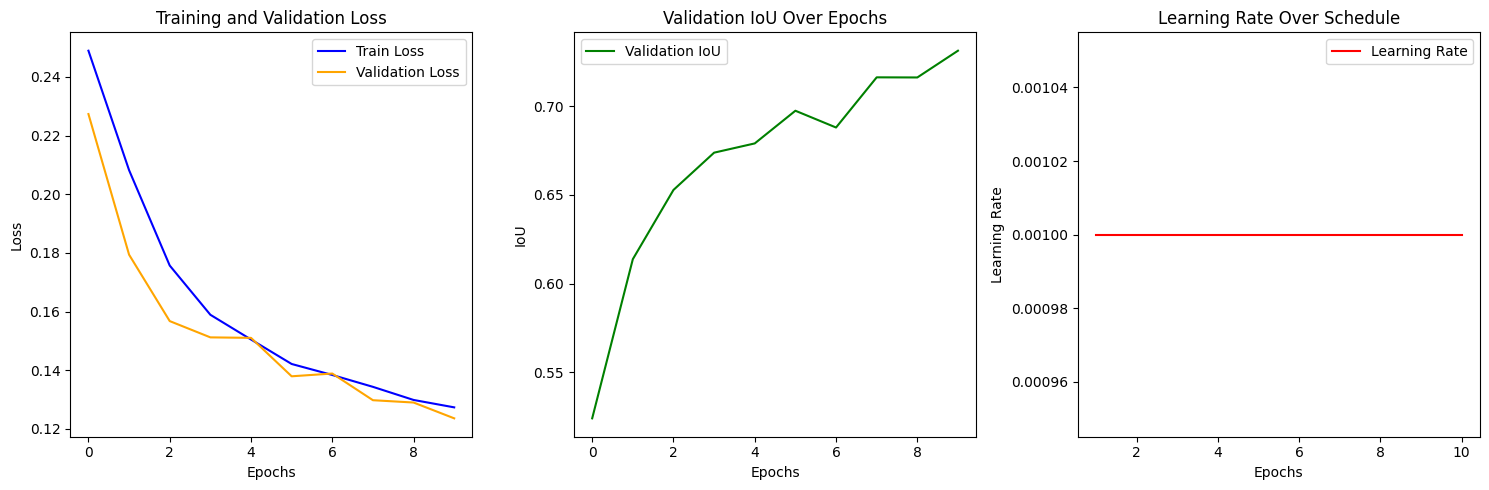

In [10]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(val_ious, label='Validation IoU', color='green')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.title('Validation IoU Over Epochs')
plt.legend()

plt.subplot(1, 3, 3)
epochs = range(1, len(train_losses) + 1)
plt.plot(epochs, [scheduler.get_last_lr()[0]] * len(epochs), label='Learning Rate', color='red')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Over Schedule')
plt.legend()

plt.tight_layout()
plt.show()

Loading Final Model for Evaluation

In [14]:
checkpoint = torch.load('final_unet_model.pth', map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

Prediction Visualization

Visualizing predictions...


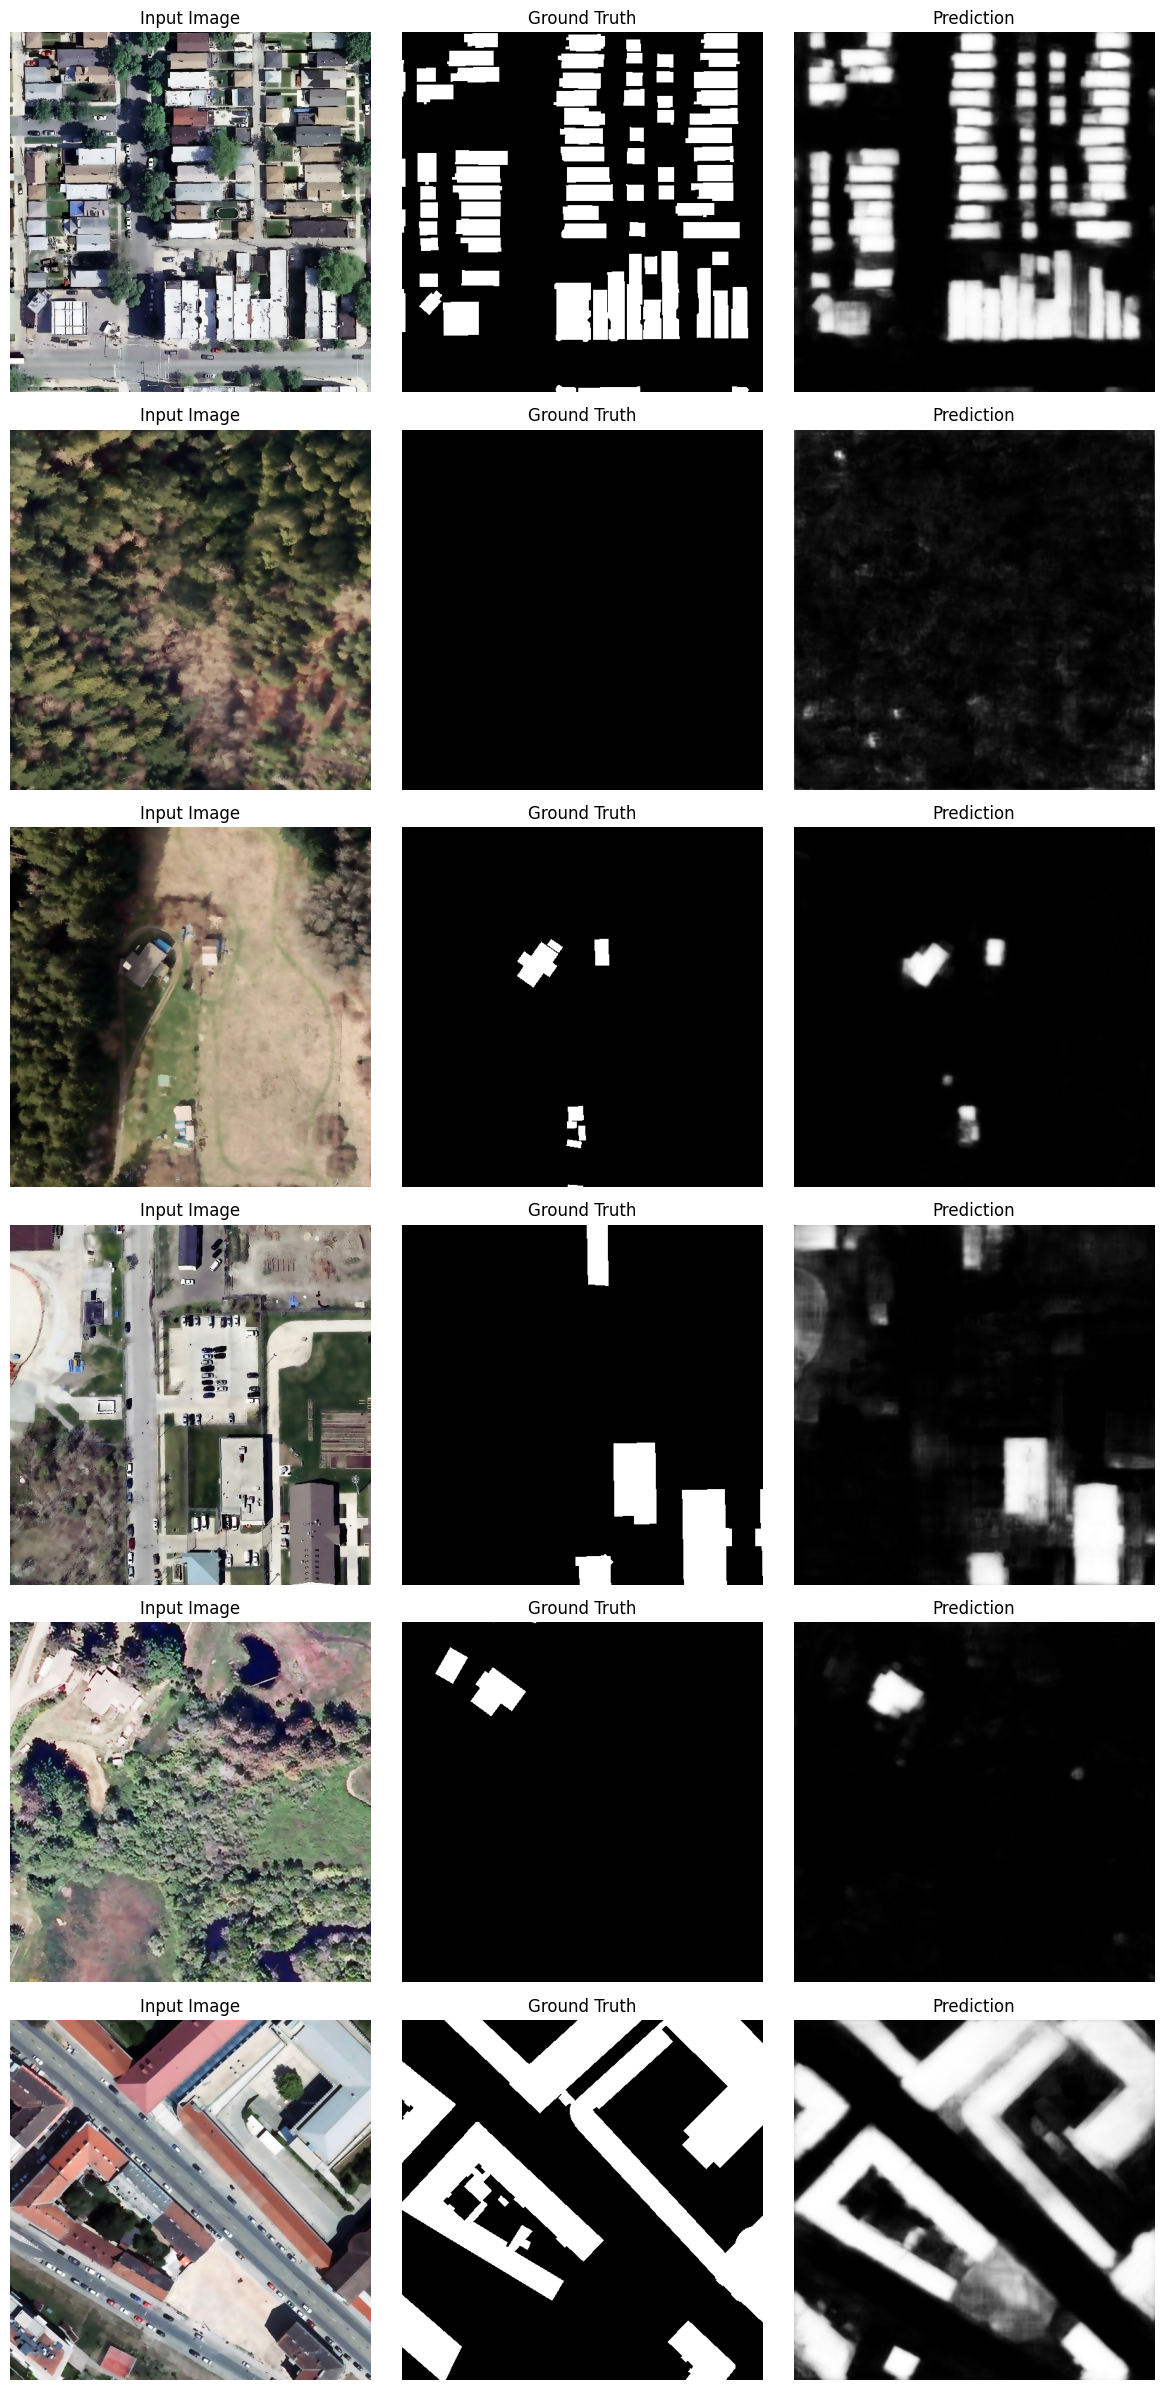

In [19]:
def visualize_predictions(model, dataset, num_samples=4):
    """Visualizing some predictions from the model"""
    model.eval()
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))
    
    indices = random.sample(range(len(dataset)), num_samples)
    
    with torch.no_grad():
        for i, idx in enumerate(indices):
            image, mask = dataset[idx]
            image_input = image.unsqueeze(0).to(device)
            
            #Getting Prediction
            prediction = model(image_input)
            prediction = torch.sigmoid(prediction).squeeze().cpu()
            
            #Converting tensors for visualization
            image_vis = image.permute(1, 2, 0).cpu().numpy()
            mask_vis = mask.squeeze().cpu().numpy()
            pred_vis = prediction.numpy()
            
            #Plotting
            axes[i, 0].imshow(image_vis)
            axes[i, 0].set_title('Input Image')
            axes[i, 0].axis('off')
            
            axes[i, 1].imshow(mask_vis, cmap='gray')
            axes[i, 1].set_title('Ground Truth')
            axes[i, 1].axis('off')
            
            axes[i, 2].imshow(pred_vis, cmap='gray')
            axes[i, 2].set_title('Prediction')
            axes[i, 2].axis('off')
            
    plt.tight_layout()
    plt.show()
    
print("Visualizing predictions...")
visualize_predictions(model, val_dataset, num_samples=6)